Copyright Amazon.com, Inc. or its affiliates. All Rights Reserved.
SPDX-License-Identifier: Apache-2.0

# Learning Gremlin - Loops and Repeat Queries

This notebook is the second in a series of notebooks that walk through how to write queries using Gremlin.  In this notebook, we will examine the basics of how to perform looping and repeating queries in Gremlin.  


This notebook assumes that you have already completed the previous notebook "01-Basic-Read-Queries" so we will continue our lessons from the end of the previous notebook and assume that the data has been loaded into the cluster. 

### Setting up the visualizations

Run the next two cells to configure various display options for our notebook, which we will use later on to display our results in a pleasing visual way.  

In [ ]:
%%graph_notebook_vis_options
{
  "groups": {    
    "person": {
      "color": "#9ac7bf"
    },
    "review": {
      "color": "#f8cecc"
    },
    "city": {
      "color": "#d5e8d4"
    },
    "state": {
      "color": "#dae8fc"
    },
    "review_rating": {
      "color": "#e1d5e7"
    },
    "restaurant": {
      "color": "#ffe6cc"
    },
    "cusine": {
      "color": "#fff2cc"
    }
  }
}

In [ ]:
node_labels = '{"person":"first_name","city":"name","state":"name","restaurant":"name","cusine":"name"}'

### Looking at our graph data

As we examined the data model in the previous notebook, we are not going to examine it, however we will leave the data schema for reference.

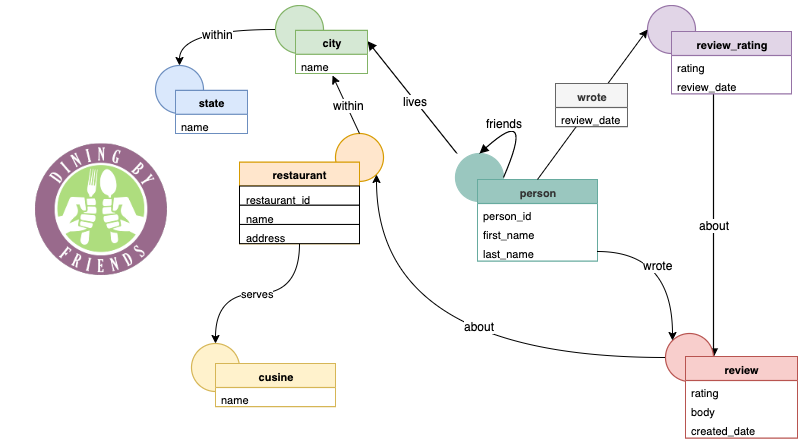


## Looping

When working with any property graph, some of the most powerful queries you can write are ones where the number of connections between a source and a target entity is not known.  These types of queries are so common that property graph query languages, such as Gremlin, have first class support as a key piece of the query language.  In Gremlin, these queries are written using a mechanism known as Looping and Repeating. Loops allow us to specify a sequence of nodes and relationships, whilst Repeats allow us to specify the number of times to repeat the relationship in the pattern matching syntax, or until an additional pattern has been matched.

In Gremlin, a basic loop query to find all nodes within 1 to 3 hops looks like:

```
g.V()
.repeat(
out()
).times(3)
```

Examining this query we see that there are two defined parts to a loop in Gremlin. The first is the `repeat()` step, which acts as a wrapper to the traversal pattern that we'd like to use. The second part defines the *limit* to be applied to the repeat (we don't want to keep traversing indefinitely!) The *limit* portion can be applied using two different mechanisms, as shown in the table below:

* `times()` - used to specify the exact number of times a `repeat()` pattern is to be executed
* `until()` - used to specify a traversal pattern that, once satisfied, will stop the `repeat()` for a traversal

Now that we have a basic understanding of Gremlin's loop syntax, let's look at how this is applied to answer some common graph query patterns.

### Static Number of Hops

The simplest looping pattern you can do in Gremlin is to specify a fixed number of hops for your pattern.  This is accomplished using the `times()` step.  Let's execute the query below to traverse outwards by 2 hops, and return the path.

In [ ]:
%%gremlin
g.V()
.repeat(
    out()
)
.times(2)
.path()
.limit(10)

### Explaining the previous Gremlin query

Using the `repeat()` step, we told Gremlin to traverse all **outgoing** edges **2 times**. The graphic below demonstrates how Gremlin creates additional traverses when there are multiple outgoing edges to follow.

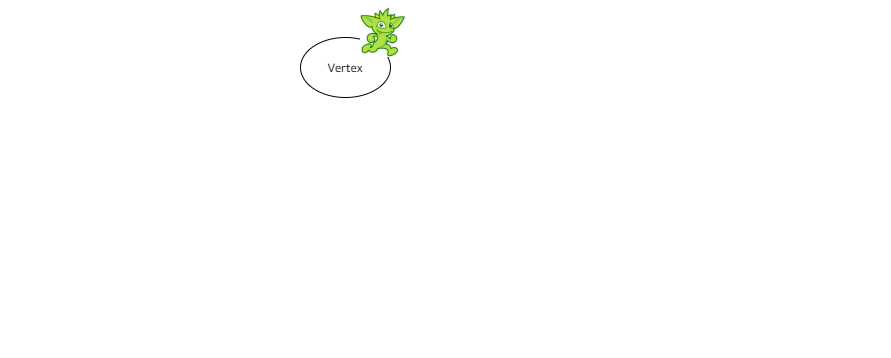

### Variable Number of Hops

While the example above works on a static number of hops, sometimes we do not know the number of connections we need to traverse to answer a question. In this case, we can use the `until()` step to specify an additional pattern that will stop a traverser once the condition is met.

**Important**. While this is a valid query, these sorts of queries tend to have a very high latency as they may traverse/touch a large portion of the graph, depending on how the graph is connected.

Execute the query below to see how many paths are connected via any number of `friends` edges. 

In [ ]:
%%gremlin -d $node_labels
g.V()
.hasLabel("person")
.repeat(
    bothE()
        .hasLabel("friends")
    .otherV()
        .hasLabel("person")
)
.until(
    not(out().hasLabel("person"))
)
.path()
.limit(10)

### Visualising Results in a Neptune Notebook
A key part of using any graph database is being able to visualise the way the objects stored within it are connected to each other. We've already shown how to do this in previous examples, however it's important to understand which of the Gremlin steps support this type of functionality.

* `path()` - used to provide access to all nodes and edges within each unique path traversed
* `simplePath()` - used to ensure we don't repeat a traversal across an object we've already covered (this can lead to infinite looping if the model supports circular references)

If you're running this in a Neptune Notebook, we can use the `path()` step we tell the notebook to automatically present a visualisation of the output of a query. The following query returns 10 paths visualising the connections between `person`, `city`, `restaurant` and `cuisine`. Run the following query, and a graphical visualisation will automatically appear.

In [ ]:
%%gremlin -d $node_labels
g.V()
    .hasLabel("person")     // start with all person nodes
    .out("lives")           // traverse the outbound "lives" edge to city
    .in("within")           // traverse the inbound edge from city to restaurant
    .where(__.inE("about")) // filter on restaurants where at least one review exists
    .out("serves")          // traverse the outbound edge from restaurant to cuisine
    .path()                 // return the path
    .limit(10)              // only return 10 results

## Exercises

Now that we have gone through the basics of looping and repeating queries in Gremlin, it's time to put it into practice. Below are several exercises you can complete to verify your understanding of the material covered in this notebook.  As practice for what you have learned, please write the Gremlin queries specified below.

### Exercise Loop-1 Find the friends of Dave's Friends using a loop

Using the data model above, write a query that will:

* Find a `person` node(s) with a `first_name` of "Dave"
* Find the friends of Dave (i.e. traverse the `friends` edge)
* Find the friends of that person (i.e. traverse the `friends` edge)
* Return the friends `first_name`

The correct answer is a three results: "Hank", "Denise", "Paras"

In [ ]:
%%gremlin -d $node_labels


### Exercise Loop-2 Find all `person` nodes connected to Dave

Starting at a single node and trying to find all connected children (a.k.a. root to leaf) or trying to find the parent of any child node (a.k.a leaf to root) are two very common hierarchical graph query patterns.  Commonly, these queries supported bill of materials, information organization, or compliance use cases.

In this exercise, we will be applying that same query pattern to find the hierarchy of people within our social network.  We'll accomplish this by writing a "root to leaf" type query where the root node is our `Dave` node in the social network.

Using the data model above, write a query that will:

* Find a `person` node(s) with a `first_name` of "Dave"
* Keep traversing the outgoing `friends` edge until there are no more outgoing `friends` edges
* Return all the paths

The correct answer is a nine results

In [ ]:
%%gremlin -d $node_labels


### Exercise Loop-3 Find if Dave and Denise are connected

Trying to see if and how, two entities in a graph are connected is a common path type query pattern. These types of queries containing unbounded path traversals with an OLTP graph database are best for calculating point to point or point to set path questions. Set to set or all pairs paths are best done with graph algorithms.

In this exercise, we will be applying a path type query pattern to find out if two people are connected.

Using the data model above, write a query that will:

* Find a `person` node(s) with a `first_name` of "Dave"
* Find the friends of Dave (i.e. traverse the `friends` edge)
* Keep traversing the `friends` edge until you find `Denise`
* Return a single `True` as the result

The correct answer is a single results: `True`

In [ ]:
%%gremlin -d $node_labels


### Exercise Loop-4 Find all the ways Dave and Denise are connected

A common extension to the path traversal query we wrote in Loop-3 is to return not just "if" someone is connected but "how" they are connected.

In this exercise, we will be making a slight modification to the previous query to return "how" Dave and Denise are connected, not just that they are.

Using the data model above, write a query that will:

* Find a `person` node(s) with a `first_name` of "Dave"
* Find the friends of Dave (i.e. traverse the `friends` edge)
* Keep traversing the `friends` edge until you find `Denise`
* Return the path

The correct answer has fifteen results

In [ ]:
%%gremlin -d $node_labels


## Conclusion

In this notebook, we explored writing looping and repeat queries in Gremlin. These queries are a powerful and common way to explore connected data to answer questions, especially those where the exact number of connection is unknown.  

In the next notebook we will take what we have learned in this notebook and extend it to demonstrate how to order, group, and aggregate values in queries.